Lone Hits Analysis
========================


[struttura dati straxen](https://straxen.readthedocs.io/en/latest/reference/datastructure.html)

è comodo usare **get_iter** per iterare sui vari chunck, si può chiamare anche più di un target però devono essere dello stesso tipo (guardare struttura dati); importante l'opzione **keep_column**

In [1]:
import sys
import os.path as osp

from copy import deepcopy
import datetime
import os
import pickle
import csv
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from multihist import Hist1d, Histdd
from tqdm.notebook import tqdm
import pandas as pd
from scipy import stats

import strax
import straxen
strax.utils.tqdm = tqdm  # use notebook-aware progress bar

In [2]:
st = straxen.contexts.xenonnt_online()

In [3]:
st.context_config['check_available'] = ('raw_records','pulse_counts','peaklets','lone_hits')

In [11]:
runs = st.select_runs(available=(['lone_hits','raw_records']),run_mode='*selftrigger*')

In [20]:
st.select_runs(run_id='00852*')

,name,number,mode,start,end,tags,livetime,tags.name,peak_basics_available,raw_records_available,lone_hits_available
1362,008520,8520,xenonnt_commissioning_pmtgain,2020-07-08 16:07:26.870,2020-07-08 16:17:27.847,,00:10:00.977000,NaN,False,False,False
1363,008521,8521,xenonnt_commissioning_noise,2020-07-08 16:19:19.098,2020-07-08 16:19:54.156,,00:00:35.058000,NaN,False,False,False
1364,008522,8522,xenonnt_selftrigger_commissioning_lowe,2020-07-08 16:41:23.339,2020-07-08 16:56:38.936,messy,00:15:15.597000,NaN,False,False,False
1365,008523,8523,xenonnt_selftrigger_commissioning_lowe,2020-07-08 16:57:11.047,2020-07-08 17:00:12.380,messy,00:03:01.333000,NaN,False,False,False
1366,008524,8524,xenonnt_selftrigger_commissioning_lowe,2020-07-08 17:00:41.492,2020-07-08 17:06:31.102,messy,00:05:49.610000,NaN,False,False,False
1367,008525,8525,xenonnt_selftrigger_commissioning_lowe,2020-07-08 17:09:19.500,2020-07-08 18:09:21.830,,01:00:02.330000,NaN,False,True,False
1368,008526,8526,xenonnt_selftrigger_commissioning_lowe,2020-07-08 18:09:53.945,2020-07-08 19:09:55.270,,01:00:01.325000,NaN,False,False,False
1369,008527,8527,xenonnt_selftrigger_commissioning_lowe,2020-07-08 19:10:25.380,2020-07-08 20:10:27.790,,01:00:02.410000,NaN,False,True,False
1370,008528,8528,xenonnt_selftrigger_commissioning_lowe,2020-07-08 20:10:59.912,2020-07-08 21:11:02.421,,01:00:02.509000,NaN,False,False,False
1371,008529,8529,xenonnt_selftrigger_commissioning_lowe,2020-07-08 21:11:34.540,2020-07-08 22:11:35.359,,01:00:00.819000,NaN,False,True,False


In [6]:
st.data_info('lone_hits')

,Field name,Data type,Comment
0,time,int64,Start time since unix epoch [ns]
1,length,int32,Length of the interval in samples
2,dt,int16,Width of one sample [ns]
3,channel,int16,Channel/PMT number
4,area,float32,Integral [ADC x samples]
5,left,int16,Index of sample in record in which hit starts
6,right,int16,Index of first sample in record just beyond hi...
7,left_integration,int16,"For lone hits, index of sample in record where..."
8,right_integration,int16,"For lone hits, index of first sample beyond in..."
9,record_i,int32,Internal (temporary) index of fragment in whic...


## Selezionati dati con funzione get_iter

I dati li chiamo usando `get_iter` che viene utilizzato in loop sui chunk (5 secondi di dati nei raw data e 16 secondi con i lone hits) su un singolo run

In [7]:
def chunk_rate(run_id, _ch):
    r_data = [('area',np.float32),('length',np.int),('chunk_dt',np.float32),
              ('area_cut',np.float32)]
    
    area=[]
    length=[]
    chunk_dt=[]
    area_cut=[]
    for chunk in st.get_iter(run_id, ['lone_hits'], max_workers=20,
                         keep_columns = ('channel', 'area', 'time','length','dt'),
                             selection_str=('channel==%i'%(_ch))):
        area.append(chunk.data['area'])
        length.append(chunk.data['length'])
        chunk_dt.append(((chunk.data['time'][-1]+chunk.data['length'][-1]*chunk.data['dt'][-1])-chunk.data['time'][0]))
        area_cut.append(chunk.data['area'][chunk.data['length']<20])
        
    return area,area_cut,length,chunk_dt, chunk.data['dt']

In [8]:
run_id = '007730'
pmt_chn = 126
area, area_cut, length, chunk_dt, dt = chunk_rate(run_id,pmt_chn)
#lone_hits = st.get_array(run_id,'lone_hits')
#pdata = st.get_array(run_id,'lone_hits',max_workers=20,_chunk_number=2)
#pdata = st.get_array(run_id,'lone_hits',max_workers=20,seconds_range=(0,30))

Text(0, 1, 'counts')

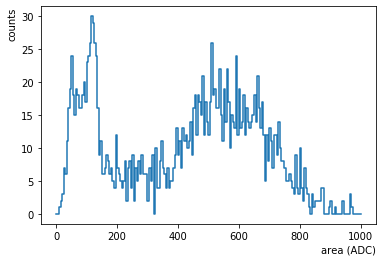

In [15]:
#area = Hist1d(pdata['area'][pdata['channel']==6],bins=200,range=(0,1000))
h_area = Hist1d(area[0],bins=200,range=(0,1000))
h_area.plot()
plt.xlabel('area (ADC)', ha='right', x=1)
plt.ylabel('counts', ha='right', y=1)

Le variabili sono dei vettori con i valori per ogni chunk, bisogna poi unire tutti i run. 

## Funzione per calcolo del gain e per il fit

Definizione di funzioni che vengono utilizzate per il fit del SPE, la funzione `dgauss_exp` è una doppia gaussiana più una funzione di Fermi che serve per separare la regione a bassa energia (legata ai dark count e eventi che non si riconoscono) dal picco di single photo-electron

In [33]:
def s_expo(x,B,t,C):
    #r = (B*np.exp(x/t))+C
    r = 1/(np.exp((x-t)/B) +1)+C
    return r

def sgauss(x,A1,u1,s1):
    arg1 = (x-u1)/s1
    arg1 *= arg1
    r = (A1/(np.sqrt(2*np.pi)*s1)*np.exp(-0.5*arg1))
    return r

def dgauss_exp(x,A1,u1,s1,A2,u2,s2,B,t,C):
    
    #1 / (np.exp((x - t)/b) + 1)
    arg1 = (x-u1)/s1
    arg1 *= arg1
    arg2 = (x-u2)/s2
    arg2 *= arg2

    r = ((A1/(np.sqrt(2*np.pi)*s1)*np.exp(-0.5*arg1))+(A2/(np.sqrt(2*np.pi)*s2)*np.exp(-0.5*arg2)))*s_expo(x,B,t,C)
    return r

def gain_calc(area, ch ,opt='adc', draw=False):
    '''
    Gain Calculation:
    INPUT:
        -- area: vector with the area for each PMTs
        -- opt: two option to calculate the gain:
                -- 'pe' = to calculate the real gain
                -- 'adc'= to calculate the gain in adc as check
        -- draw: Boolean if you want to draw plot or not
    
    OUTPUT:
        -- fit_par: fit parameters from curve_fit
        -- fit_cov: covariant matrix from curve_fit
    
    '''
    sample_duration = 10 # ns
    digitizer_voltage_range = 2.25 # V
    digitizer_bits = 14
    pmt_circuit_load_resistor = 50 # Ohm
    external_amplification = 10
    electron_charge = 1.602e-19

    adc_to_e = sample_duration * 1e-9 * digitizer_voltage_range / (2 ** (digitizer_bits) * pmt_circuit_load_resistor * external_amplification * electron_charge)
    print(adc_to_e)
    f0=[]
    count=[]
    bs=[]
    zz=[]
   
    plt.figure(figsize = (10,8))
    if opt=='adc':
        count,bs,zz = plt.hist(area,
                               bins=400,range=(0,1500),
                               label='PMT: %i'%(ch),
                               histtype='step', )
        #f0=[100000.,100.,15.,100000.,900.,1000.,100000.,-10.,1.]
        f0=[100000.,100.,15.,100000.,900.,1000.,1.,100.,0.]

    
    if opt=='pe':
        count,bs,zz = plt.hist(area*17144, #* (2.25 / 2**14) / 50 /10 * 10e-9 / 1.6e-19/1e6,
                               bins=400,range=(0,20),
                               label='PMT: %i'%(ch),
                               histtype='step', )
        f0=[10000.,2.,.3,10.,90000, 8, 1.0, -0.01,1.0]
        #bounds = ([0,0,0,0,0,0,-0.01,-0.01,-0.01],[0,0,0,0,0,0,0.01,0.01,0.01])

        
    cbin=(bs[:-1]+bs[1:])/2
    #print(bs.shape,cbin.shape)
    #A1,u1,  s1, A2, u2,  s2,  B,  t,   C
            
    fit_par,fit_cov=curve_fit(dgauss_exp,cbin,count,f0,);
    
    if draw:
        plt.plot(cbin,dgauss_exp(cbin,*fit_par),'r')
        plt.plot(cbin,sgauss(cbin,*fit_par[:3]),'b--')
        plt.plot(cbin,sgauss(cbin,*fit_par[3:6]),'g--')
        fit_par[8] *= 1000
        plt.plot(cbin,s_expo(cbin,*fit_par[6:]),'k--')
        
        #print(fit_par)
        if opt=='adc':
            plt.xlabel('Lone_hit Area')
        if opt=='pe':
            plt.xlabel('Gain x 1e6')
            
        plt.ylabel('ADC counts')
    
        plt.legend()
        plt.show()
    return fit_par,fit_cov

## Fit del Single Photo-Electron peak

La funzione seguente li unisce e poi fa il fit utilizzando le funzioni che sono definite

In [34]:
from scipy.optimize import curve_fit
def build_area(area,length,chk_dt,ch,opt='adc',draw=False):
    ar=[]
    lgth=[]
    rate=[]
    for i in range(len(area)):
        for k in range(len(area[i][:])):
            ar.append(area[i][k])
            lgth.append(length[i][k])
        rate.append(len(area[i])/chk_dt[i])
    #print(len(ar))
    fit_par,fit_cov = gain_calc(ar,ch,opt,draw);
    
    #fit_par_c,fit_cov_c = gain_calc(ar,ch,opt,draw);
    plt.figure(figsize=(10,8))
    #plt.subplot(2,1,1)
    #plt.subplot(2,1,2)
    h1=Histdd(ar,lgth,bins=(400,40),range=([0.,1500],[0,45]) )
    h1.plot('log')
    return fit_par,fit_cov, ch ,ar, rate
    #print(fit_par,fit_cov)

17144.706811797754


/dali/lgrandi/strax/miniconda3/envs/strax/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in exp
  This is separate from the ipykernel package so we can avoid doing imports until


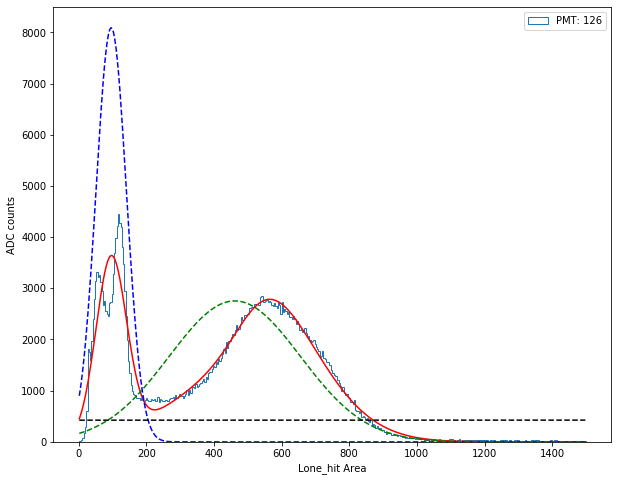

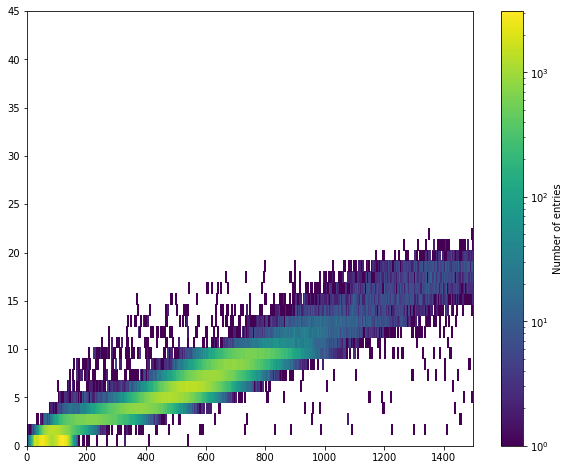

In [35]:
fp, fc, ch, a, rate = build_area(area, length, chunk_dt, pmt_chn,opt='adc',draw=True)

Conversione in carica
-------------------
Il PMT ha in uscita un impulso di corrente che se integrata nel tempo dà la carica rilasciata totale. La variabile **area** utilizzata nell'istogramma precedente, è calcolata sulla waveform somma dei PMT ed è espressa in canali del FADC.

La carica totale che arriva ai PMT si può scrivere come:

$Q=n\cdot e^-=\int_0^{t*} i(t) dt = \int_0^{t*} \frac{V(t)}{R} dt = \dfrac{V_{tot}}{R} \cdot \Delta t$

Per calcolare la carica bisogna tenere conto anche della conversione da canali ADC in Volt.

* $V_{max} = 2.25~$V (ampiezza massima in volt del'ADC)
* $n_{samples} = 2^{14}$ (l'ADC è a 14 bit)
* $R = 50~\Omega$ (impedenza del cavo)
* $\Delta t = 10~$ns (sample width)

$Q= \dfrac{area}{R} \cdot \Delta t\cdot \dfrac{V_{max}}{n_{samples}}$

per calcolare il numero di elettroni basta dividere per la carica dell'elettrone:

$n = \dfrac{Q}{e^-}$

Il gain del PMT si calcola dal picco di Single Photo-Electron (SPE).

In [45]:
def pmt_gain(id,plot=True):
    Z = 50
    e = 1.6021766208e-19
    w = 1e-9
    r = 2.25/2**14
    
    conv = r*w/(Z*1e-12)
    # PMT total charge
    pmt_charge = Hist1d(pdata['area'][pdata['channel']==id]*conv,
                        bins=200, range=(0,5) )
    #plt.hist(pdata['area'][pdata['channel']==id]*conv,
             #bins=200,range=(0,2),label=f"PMT n. {id}",
            #histtype='step')
    if plot:
        plt.figure(1)
        pmt_charge.plot(label=f"PMT n. {id}")
        plt.xlabel('total charge (pC)')
        plt.ylabel('counts', ha='right', y=1)
        plt.legend()
    
    # gain calculation
    el_hist, el_bin = np.histogram(pdata['area'][pdata['channel']==id]*conv/e*1e-18,
             bins=200, range=(0,30))
    bin_max = np.where(el_hist > el_hist.max()*0.8)
    gain = np.average(el_bin[bin_max])
    if plot:
        plt.figure(2)
        plt.plot(el_bin[1:],el_hist,label=f"PMT n. {id}, gain: {gain:.1f}$\cdot 10^6$")
        plt.xlabel('number of electrons $x10^6$')
        plt.ylabel('counts', ha='right', y=1)
        plt.legend()
    if np.isnan(gain): gain = 0
    return gain

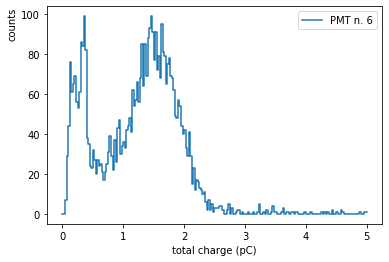

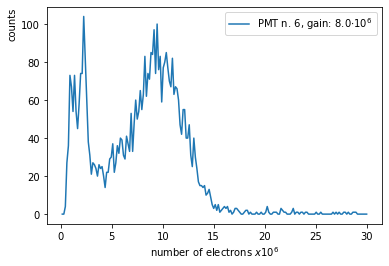

In [40]:
for i in range(1):
    pmt_gain(i+6)

# Event Selection

(<matplotlib.collections.QuadMesh at 0x7f9b825bd250>,
 <matplotlib.colorbar.Colorbar at 0x7f9b826261d0>)

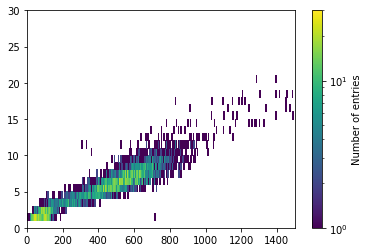

In [41]:
area_vs_length = Histdd(pdata['area'][pdata['channel']==356],pdata['length'][pdata['channel']==356],
                        bins=(500,30),range=([0,1500],[0,30]))

area_vs_length.plot('log')

In [42]:
import nt_layout as nt

def pmt_plot(target, PMTs, active_channels,
             label='', figsize=(15, 4), s=230, alpha=1,
             pmt_label_size=7, pmt_label_color='white',
             log_scale=False, extend='neither', vmin=None, vmax=None,
             **kwargs):
    
    """Plots the PMT arrays, using c as a color scale"""
    
    if vmin is None: vmin = target.min() 
    if vmax is None: vmax = target.max() 
    
    r = 79.79 * 1.01 #slightly enlarged tpc radius
    
    f, axes = plt.subplots(2, 1, figsize=figsize)
    for array_i, array_name in enumerate(['top', 'bottom']):
        ax = axes[array_i]
        ax.tick_params(labelsize = 16)
        plt.sca(ax)
        ax.set_aspect('equal')
            
        plt.xlim(-r, r)
        plt.ylim(-r, r)

        #active channels
        pos_x = []
        pos_y = []
        pmt_num = []
        mask_list = []

        #inactive channels
        pos_x_missing = []
        pos_y_missing = []
        pmt_num_missing = []
        mask_list_missing = []

        plt.title(f'Channels:{array_name.capitalize()}',fontsize=20)
        for i in range(len(PMTs)):
            if not PMTs['pmt'][i] in active_channels:
                mask = PMTs['array'][i] == array_name
                mask_list_missing.append(mask)
                if mask == True:
                    pos_x_missing.append(PMTs['x'][i])
                    pos_y_missing.append(PMTs['y'][i])
                    pmt_num_missing.append(PMTs['pmt'][i])
            else:
                mask = PMTs['array'][i] == array_name
                mask_list.append(mask)
                if mask == True:
                    pos_x.append(PMTs['x'][i])
                    pos_y.append(PMTs['y'][i])
                    pmt_num.append(PMTs['pmt'][i])

        plt.scatter(pos_x, pos_y, s=s, c=target[mask_list], alpha=alpha, vmin=vmin, vmax=vmax,
                    norm=matplotlib.colors.LogNorm() if log_scale else None, **kwargs)

        plt.xlabel('distance (cm)',fontsize=16)
        plt.ylabel('distance (cm)',fontsize=16)
        
        #label active channels
        if pmt_label_size:
            for p in range(len(pos_x)):
                plt.text(pos_x[p], pos_y[p], str(pmt_num[p]),
                         horizontalalignment='center', verticalalignment='center',
                         fontsize=pmt_label_size, color=pmt_label_color)

        #label missing channels
        if pmt_label_size:
            for p in range(len(pos_x_missing)):
                plt.text(pos_x_missing[p], pos_y_missing[p], 'X',
                         horizontalalignment='center', verticalalignment='center',
                         fontsize=pmt_label_size*2, color='red')
    
    cbar = plt.colorbar(ax=axes, extend=extend, label=label)
    cbar.set_label(label, size=20)
    cbar.ax.tick_params(labelsize=20)


In [43]:
PMTs = nt.PMT_info('hv_connector_20032020.csv','xenonnt_cable_map.csv',False)

In [44]:
rr = st.get_array(run_id, 'raw_records', seconds_range=(0, 2))

DataNotAvailable: Time range selection assumes data is already available, but raw_records for 007730 is not.

In [241]:
rr = np.sort(rr, order='channel') #sort data by channel number
channels = np.arange(0,494,1)
active_channels = np.unique(rr[rr['channel'] <= 493]['channel'])
n_pmt = len(active_channels)
print(f"Got signals from {n_pmt} channels\n")

Got signals from 490 channels



In [270]:
gains = np.zeros(n_pmt)
for i in range(n_pmt):
    gains[i] = pmt_gain(i,False)

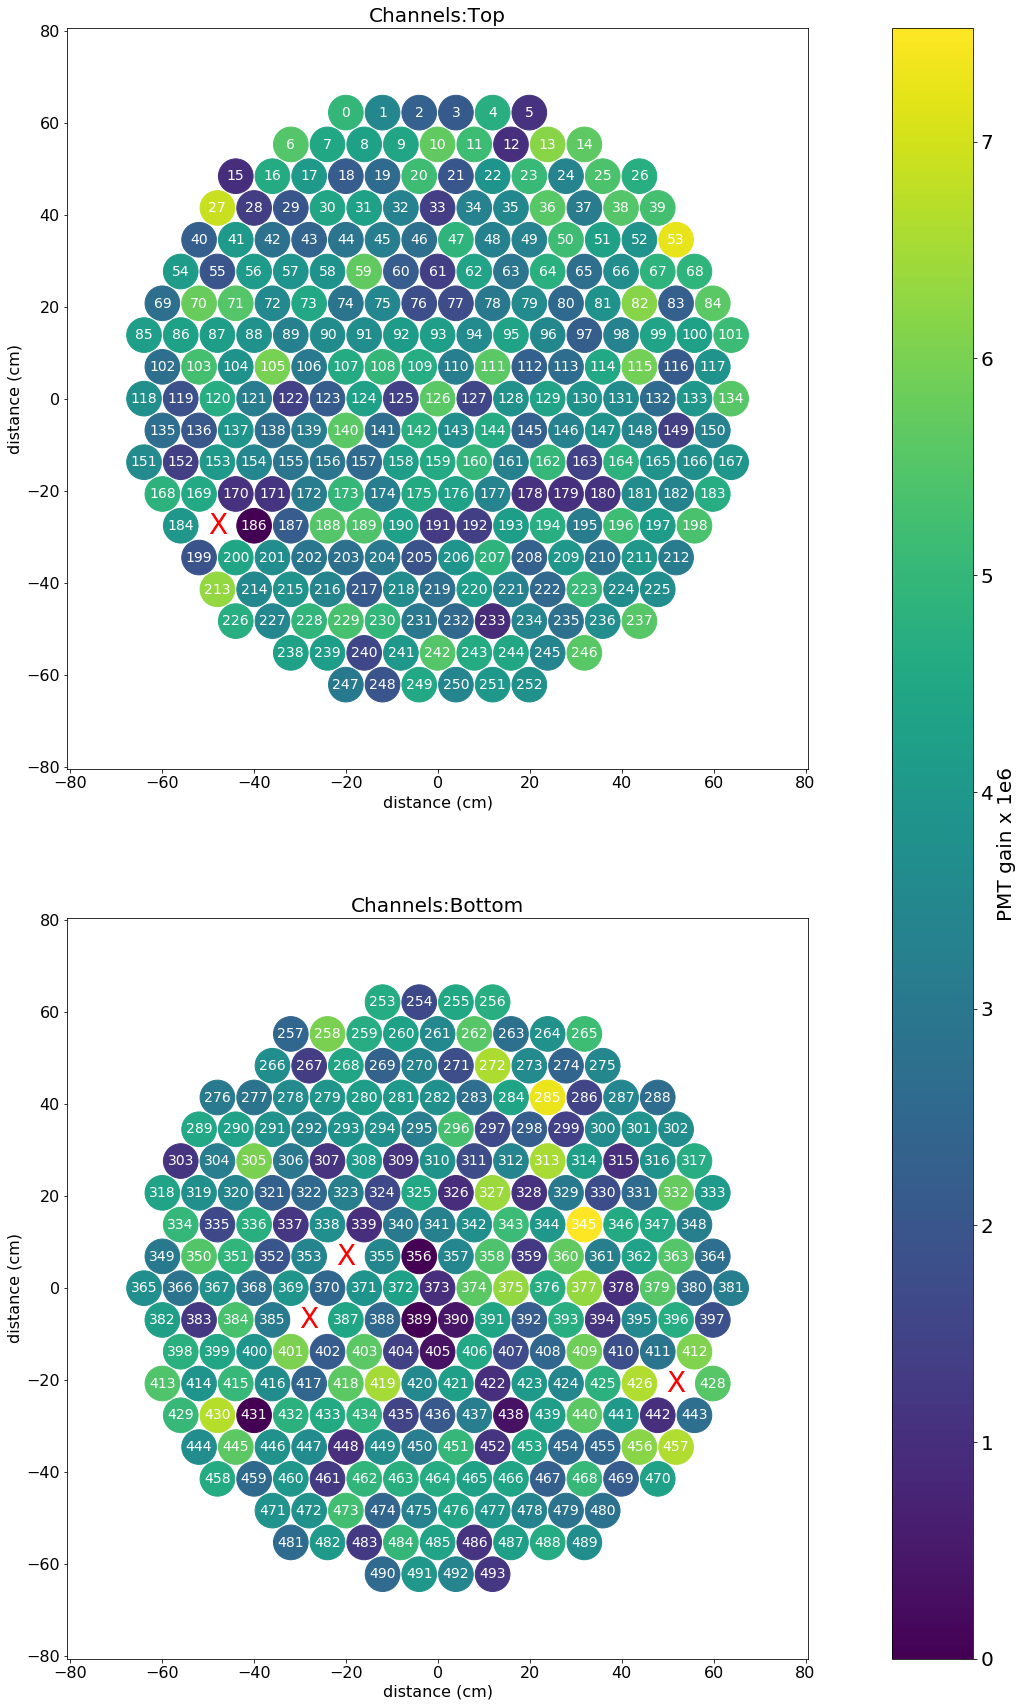

In [282]:
pmt_plot(gains,PMTs,active_channels,figsize=(30, 30),s=1200,pmt_label_size=14, label='PMT gain x 1e6')

1.15

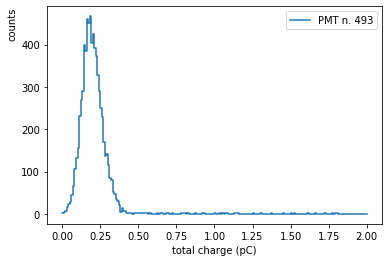

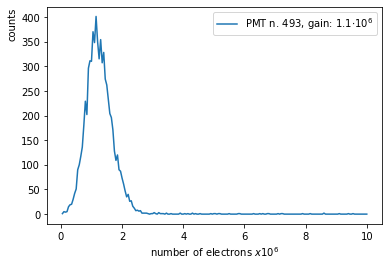

In [300]:
pmt_gain(493)